In [60]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [61]:
import numpy as np
import scipy as sp
import sklearn as sk
import cartopy as cp
import xarray as xr
import pandas as pd
import cftime
import dateutil
import dask
#Use the 2 lines below if the notebook has a dark theme (to make labelling visible):
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)
import matplotlib.pyplot as plt
#The following code resets the default plot size so you don't have to fiddle with figsize every time"
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [62]:
#Need the following line to avoid hdf5 issues that prevent opening thee file
# https://stackoverflow.com/questions/49317927/errno-101-netcdf-hdf-error-when-opening-netcdf-file
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [63]:
#Load AIRI data 
from netCDF4 import Dataset
from datetime import datetime, timedelta
from netCDF4 import num2date, date2num
dataset_file = "pALLIN.nc"
airi_dat = xr.open_dataset(dataset_file, decode_times=False)
units, reference_date = airi_dat.time.attrs['units'].split('since')
airi_dat['time'] = pd.date_range(start=reference_date, periods=airi_dat.sizes['time'], freq='MS')
#This file's calendar isn't recognized when using xr.open_dataset. The above workaround is from: 
#https://stackoverflow.com/questions/55648630/how-to-decode-the-time-variable-while-using-xarray-to-load-a-netcdf-file
# "M" means "month end frequency" (see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

#### airi_dat

In [179]:
precip = airi_dat['precip']
precip.time

<xarray.DataArray 'time' (time: 1752)>
array(['1871-02-01T00:00:00.000000000', '1871-03-01T00:00:00.000000000',
       '1871-04-01T00:00:00.000000000', ..., '2016-11-01T00:00:00.000000000',
       '2016-12-01T00:00:00.000000000', '2017-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1871-02-01 1871-03-01 ... 2017-01-01

In [65]:
#Load SLP data
#dataset_file = "data/prmsl.mon.mean.nc"
#dataset_file = "data/20thcenturyslpreanalysis.nc"
slp_dat = xr.open_dataset('/global/scratch/medhap02/prmsl.mon.mean.nc')
#units, reference_date = slp_dat.time.attrs['units'].split('since')
#slp_dat['time'] = pd.date_range(start=reference_date, periods=slp_dat.sizes['time'], freq='MS')
slp = slp_dat['prmsl']

In [66]:
slp_dat

<xarray.Dataset>
Dimensions:    (lat: 181, lon: 360, nbnds: 2, time: 2160)
Coordinates:
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time       (time) datetime64[ns] 1836-01-01 1836-02-01 ... 2015-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    prmsl      (time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.2
    title:                     Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
    comments:                  Data are from \nNOAA/CIRES/DOE 20th Century Re...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    license:                   These data are available free of charge under ...
    creator_name:              NOAA/ESRL PSD
    spatial_resolution:        1.0 degree
    platform:                  Model
    institution:               NOAA ESRL Physic

In [181]:
#Slice SLP data to the same duration as precip and calculate monthly anomalies
slp_subset = slp.sel(time=slice('1871-01-01','2015-12-31'))
slp_clim = slp_subset.groupby('time.month').mean('time')
slp_anomfull = slp_subset.groupby("time.month")-slp_clim
slp_anomfull


<xarray.DataArray 'prmsl' (time: 1740, lat: 181, lon: 360)>
array([[[  114.765625,   114.765625, ...,   114.765625,   114.765625],
        [   94.78125 ,    94.46875 , ...,    95.359375,    95.03125 ],
        ...,
        [  293.65625 ,   293.95312 , ...,   293.20312 ,   293.4297  ],
        [  288.66406 ,   288.66406 , ...,   288.66406 ,   288.66406 ]],

       [[   75.84375 ,    75.84375 , ...,    75.84375 ,    75.84375 ],
        [   67.66406 ,    68.02344 , ...,    66.85156 ,    67.24219 ],
        ...,
        [  587.2969  ,   587.52344 , ...,   586.9219  ,   587.0781  ],
        [  581.14844 ,   581.14844 , ...,   581.14844 ,   581.14844 ]],

       ...,

       [[ -876.5703  ,  -876.5703  , ...,  -876.5703  ,  -876.5703  ],
        [ -937.10156 ,  -936.8594  , ...,  -937.625   ,  -937.3906  ],
        ...,
        [-1008.4375  , -1008.8906  , ..., -1007.5625  , -1007.9922  ],
        [-1047.0938  , -1047.0938  , ..., -1047.0938  , -1047.0938  ]],

       [[ -525.5     ,  -525.5

In [250]:
slp_subset1 = slp_anomfull.sel(time=slice('1900-01-01','1901-12-31'))
slp_subset2 = slp_anomfull.sel(time=slice('1903-01-01','1906-12-31'))
slp_subset3 = slp_anomfull.sel(time=slice('1908-01-01','1911-12-31'))
slp_subset4 = slp_anomfull.sel(time=slice('1913-01-01','1913-12-31'))
slp_subset5 = slp_anomfull.sel(time=slice('1915-01-01','1918-12-31'))
slp_subset6 = slp_anomfull.sel(time=slice('1920-01-01','1921-12-31'))
slp_subset7 = slp_anomfull.sel(time=slice('1923-01-01','1927-12-31'))
slp_subset8 = slp_anomfull.sel(time=slice('1929-01-01','1931-12-31'))
slp_subset9 = slp_anomfull.sel(time=slice('1934-01-01','1939-12-31'))
slp_subset10 = slp_anomfull.sel(time=slice('1941-01-01','1948-12-31'))
slp_subset11 = slp_anomfull.sel(time=slice('1951-01-01','1955-12-31'))
slp_subset12 = slp_anomfull.sel(time=slice('1957-01-01','1958-12-31'))
slp_subset13 = slp_anomfull.sel(time=slice('1960-01-01','1962-12-31'))
slp_subset13 = slp_anomfull.sel(time=slice('1964-01-01','1965-12-31'))
slp_subset14 = slp_anomfull.sel(time=slice('1967-01-01','1971-12-31'))
slp_subset15 = slp_anomfull.sel(time=slice('1973-01-01','1976-12-31'))
slp_subset16 = slp_anomfull.sel(time=slice('1978-01-01','1979-12-31'))
slp_subset17 = slp_anomfull.sel(time=slice('1981-01-01','1982-12-31'))
slp_subset18 = slp_anomfull.sel(time=slice('1984-01-01','1991-12-31'))
slp_subset19 = slp_anomfull.sel(time=slice('1993-01-01','1998-12-31'))
slp_subset20 = slp_anomfull.sel(time=slice('2000-01-01','2002-12-31'))
slp_subset21 = slp_anomfull.sel(time=slice('2004-01-01','2006-12-31'))
slp_subset22 = slp_anomfull.sel(time=slice('2008-01-01','2010-12-31'))
slp_subset23 = slp_anomfull.sel(time=slice('2012-01-01','2015-12-31'))

slp_anomtemp = xr.merge([slp_subset1, slp_subset2, slp_subset3, slp_subset4, slp_subset5, 
                   slp_subset6, slp_subset7, slp_subset8, slp_subset9, slp_subset10, 
                   slp_subset11, slp_subset12, slp_subset13, slp_subset14, slp_subset15, 
                   slp_subset16, slp_subset17, slp_subset18, slp_subset19, slp_subset20, 
                   slp_subset21, slp_subset22, slp_subset23])
#slp_anom = xr.Dataset.to_array(slp_anomtemp).drop('variable')
print(slp_anomtemp)
slp_anom = slp_anomtemp['prmsl']
#1902, 1907, 1912, 1914, 1919, 1922, 1928, 1932, 1933, 1940
#1949, 1950, 1956, 1959, 1963, 1966, 1972, 1977, 1980, 1983
#1992, 1999, 2003, 2007, 2011

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 1056)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2015-12-01
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
    month    (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables:
    prmsl    (time, lat, lon) float32 24.570312 24.570312 ... -411.48438


<xarray.DataArray 'prmsl' (time: 1056, lat: 181, lon: 360)>
array([[[   24.570312,    24.570312, ...,    24.570312,    24.570312],
        [   13.164062,    13.367188, ...,    12.90625 ,    13.023438],
        ...,
        [  138.10938 ,   138.84375 , ...,   136.86719 ,   137.5     ],
        [  180.11719 ,   180.11719 , ...,   180.11719 ,   180.11719 ]],

       [[ -274.73438 ,  -274.73438 , ...,  -274.73438 ,  -274.73438 ],
        [ -285.      ,  -285.14844 , ...,  -284.71875 ,  -284.91406 ],
        ...,
        [ 1055.6328  ,  1054.8984  , ...,  1056.9766  ,  1056.2969  ],
        [ 1004.9844  ,  1004.9844  , ...,  1004.9844  ,  1004.9844  ]],

       ...,

       [[ -876.5703  ,  -876.5703  , ...,  -876.5703  ,  -876.5703  ],
        [ -937.10156 ,  -936.8594  , ...,  -937.625   ,  -937.3906  ],
        ...,
        [-1008.4375  , -1008.8906  , ..., -1007.5625  , -1007.9922  ],
        [-1047.0938  , -1047.0938  , ..., -1047.0938  , -1047.0938  ]],

       [[ -525.5     ,  -525.5

In [252]:
from cartopy import config
import cartopy.crs as ccrs

from matplotlib import pyplot
import matplotlib.patches as mpatches

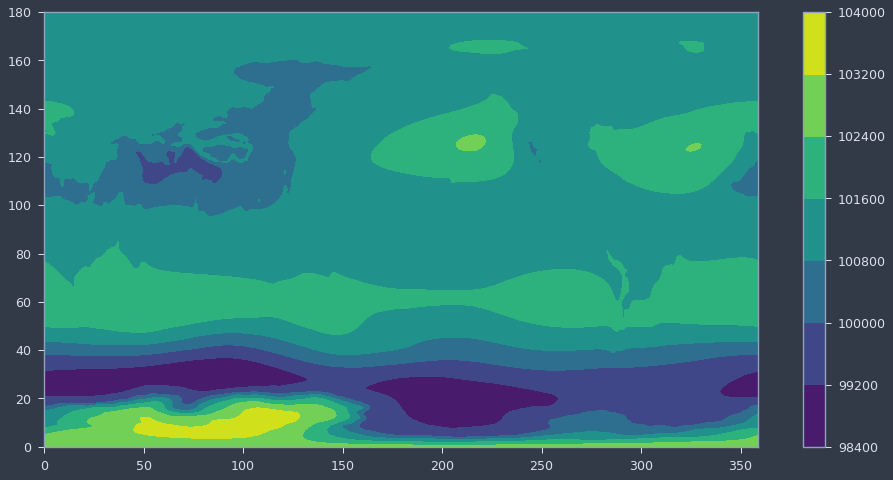

In [253]:
plt.contourf(slp_clim.sel(month=6))
plt.colorbar()

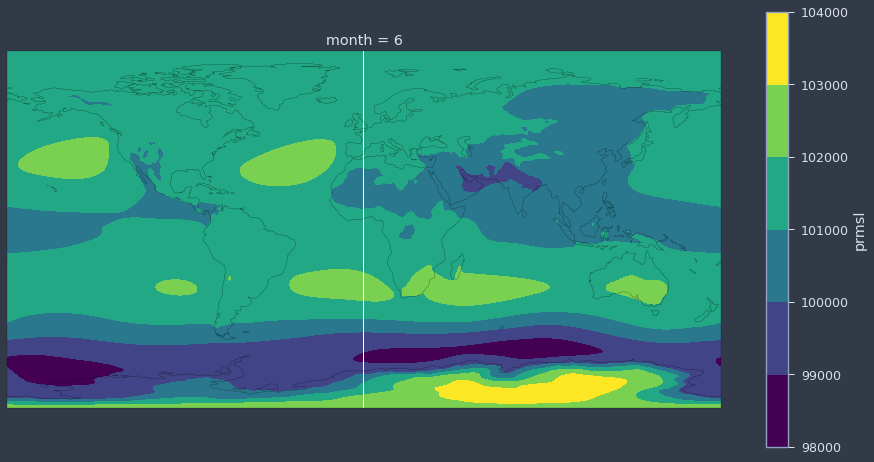

In [254]:
#Test plot of slp_clim

ax = plt.axes(projection=ccrs.PlateCarree())
#plt.contourf(slp_clim.sel(month=6))
slp_clim.sel(month=6).plot.contourf()
ax.coastlines(color='black')
#ax.add_patch(mpatches.Rectangle(xy=[-40,-160], width=30, height=70, facecolor=None, edgecolor='white', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#ax.set_extent([-30,160,0,40],crs=ccrs.PlateCarree(central_longitude=0)); 

#(40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)mega-ENSOpredictorNATMay minus March SLP averaged over(45°N–60°N, 95°E–125°E)Anomalous
    
#plt.colorbar()
#did i do this wrong, not able to see the land masses in black, or do land masses also have slp

In [255]:
#Get precip anomalies
precip_clim = precip.groupby("time.month").mean("time")
precip_anomfull = precip.groupby("time.month") - precip_clim

In [269]:
precip_subset1 = precip_anomfull.sel(time=slice('1900-01-01','1901-12-31'))
precip_subset2 = precip_anomfull.sel(time=slice('1903-01-01','1906-12-31'))
precip_subset3 = precip_anomfull.sel(time=slice('1908-01-01','1911-12-31'))
precip_subset4 = precip_anomfull.sel(time=slice('1913-01-01','1913-12-31'))
precip_subset5 = precip_anomfull.sel(time=slice('1915-01-01','1918-12-31'))
precip_subset6 = precip_anomfull.sel(time=slice('1920-01-01','1921-12-31'))
precip_subset7 = precip_anomfull.sel(time=slice('1923-01-01','1927-12-31'))
precip_subset8 = precip_anomfull.sel(time=slice('1929-01-01','1931-12-31'))
precip_subset9 = precip_anomfull.sel(time=slice('1934-01-01','1939-12-31'))
precip_subset10 = precip_anomfull.sel(time=slice('1941-01-01','1948-12-31'))
precip_subset11 = precip_anomfull.sel(time=slice('1951-01-01','1955-12-31'))
precip_subset12 = precip_anomfull.sel(time=slice('1957-01-01','1958-12-31'))
precip_subset13 = precip_anomfull.sel(time=slice('1960-01-01','1962-12-31'))
precip_subset13 = precip_anomfull.sel(time=slice('1964-01-01','1965-12-31'))
precip_subset14 = precip_anomfull.sel(time=slice('1967-01-01','1971-12-31'))
precip_subset15 = precip_anomfull.sel(time=slice('1973-01-01','1976-12-31'))
precip_subset16 = precip_anomfull.sel(time=slice('1978-01-01','1979-12-31'))
precip_subset17 = precip_anomfull.sel(time=slice('1981-01-01','1982-12-31'))
precip_subset18 = precip_anomfull.sel(time=slice('1984-01-01','1991-12-31'))
precip_subset19 = precip_anomfull.sel(time=slice('1993-01-01','1998-12-31'))
precip_subset20 = precip_anomfull.sel(time=slice('2000-01-01','2002-12-31'))
precip_subset21 = precip_anomfull.sel(time=slice('2004-01-01','2006-12-31'))
precip_subset22 = precip_anomfull.sel(time=slice('2008-01-01','2010-12-31'))
precip_subset23 = precip_anomfull.sel(time=slice('2012-01-01','2015-12-31'))

precip_anom = xr.merge([precip_subset1, precip_subset2, precip_subset3, precip_subset4, precip_subset5, 
                   precip_subset6, precip_subset7, precip_subset8, precip_subset9, precip_subset10, 
                   precip_subset11, precip_subset12, precip_subset13, precip_subset14, precip_subset15, 
                   precip_subset16, precip_subset17, precip_subset18, precip_subset19, precip_subset20, 
                   precip_subset21, precip_subset22, precip_subset23])
precip_anomtemp = xr.Dataset.to_array(precip_anom)
precip_anom = precip_anom['precip']
print(precip_anom)
#1902, 1907, 1912, 1914, 1919, 1922, 1928, 1932, 1933, 1940
#1949, 1950, 1956, 1959, 1963, 1966, 1972, 1977, 1980, 1983
#1992, 1999, 2003, 2007, 2011

<xarray.DataArray 'precip' (time: 1056)>
array([ -9.166439,   4.535616,  -5.745206, ..., -44.439735, -40.930824,
        13.444523], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2015-12-01
    month    (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 8.0 9.0 10.0 11.0 12.0


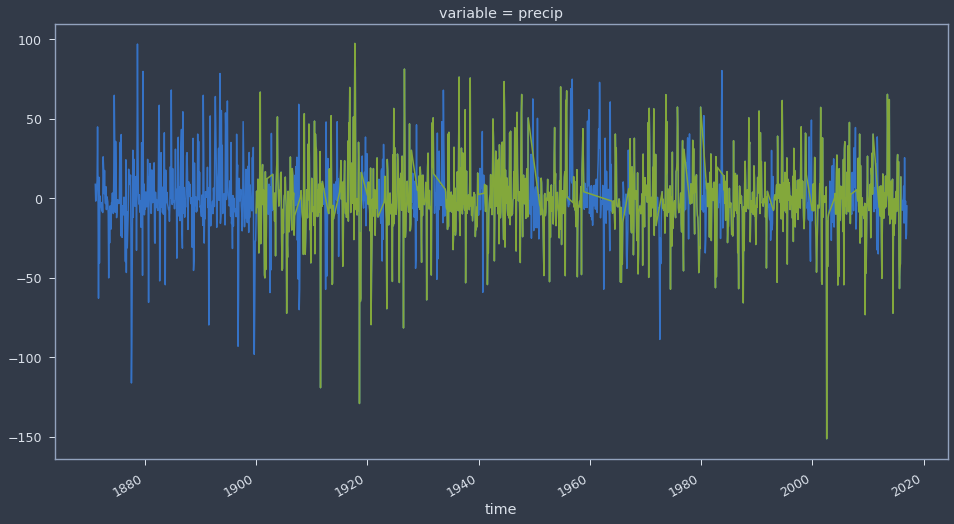

In [270]:
precip_anomfull.plot()
precip_anomtemp.plot()

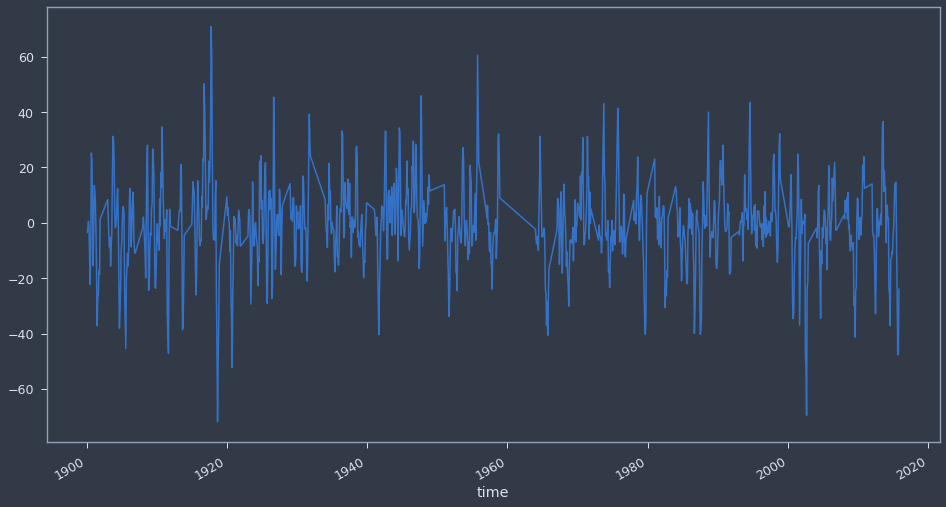

In [276]:
#Seasonal means of precip anomalies
precipa_seasonal = precip_anom.rolling(time=3,center=True).mean()
precipa_seasonal
precipa_seasonal.plot()

In [277]:
#Seasonal means of SLPA
slpa_seasonal = slp_anom.rolling(time=3,center=True).mean()
#slpa_seasonal = xr.DataArray.reset_index(slpa_seasonal, 'variable')
#slpa_seasonal = xr.DataArray.squeeze(slpa_seasonal, 'variable')
slpa_seasonal.dims

('time', 'lat', 'lon')

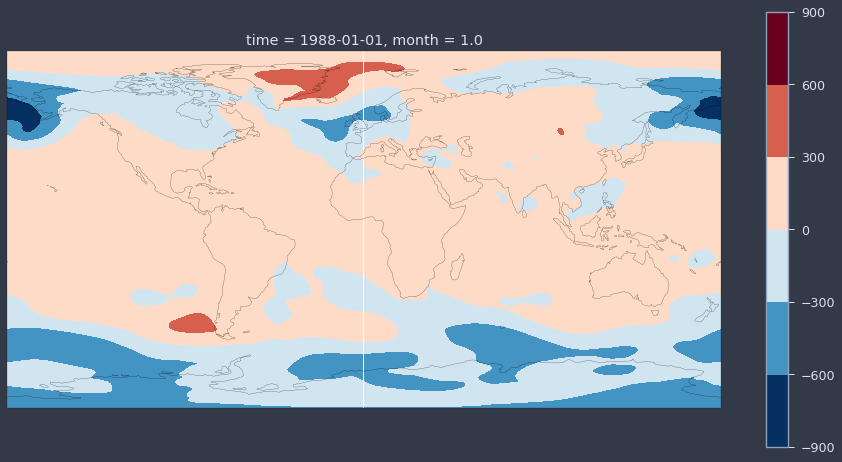

In [278]:
#Test plot of seasonal SLP anomalies in DJF 1997-8
#plt.contourf(slpa_seasonal.sel(time='1998-01-01'))
#plt.colorbar()
ax = plt.axes(projection=ccrs.PlateCarree())
slpa_seasonal.sel(time='1988-01-01').plot.contourf()
ax.coastlines()

In [279]:
#There is no inbuilt xarray correlation function so I used Ryan Abernathey's functions from:
#https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html
#NANs will RUIN EVERYTHING. Drop all leading/trailing NaNs after making a seasonal mean.
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

# correlation starts here

In [288]:
#First, try correlation map with no lag. This should give us r ~= -0.5 in the Tropical Pacific.
x = slpa_seasonal[1:-1,:,:]
y = precipa_seasonal[1:-1]
slp_r = correlation(x, y, dims='time')
#slp_rtemp['variable'] = slp_rtemp['variable'].sel(drop=True)
#slp_rtemp = xr.DataArray.reset_index(slp_rtemp, 'variable')
#slp_r = xr.DataArray.squeeze(slp_rtemp, 'variable')
#y = slpa_seasonal.sel(lat=0,lon=270)[1:-1]
#dims = 'time'
print(x.time)
print(y.time)
#slp_r = slp_r.drop('variable')
slp_r.squeeze()
print(slp_r.dims)

<xarray.DataArray 'time' (time: 1054)>
array(['1900-02-01T00:00:00.000000000', '1900-03-01T00:00:00.000000000',
       '1900-04-01T00:00:00.000000000', ..., '2015-09-01T00:00:00.000000000',
       '2015-10-01T00:00:00.000000000', '2015-11-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1900-02-01 1900-03-01 ... 2015-11-01
    month    (time) float64 2.0 3.0 4.0 5.0 6.0 7.0 ... 7.0 8.0 9.0 10.0 11.0
Attributes:
    avg_period:          0000-01-00 00:00:00
    prev_avg_period:     0000-00-01 00:00:00
    long_name:           Time
    delta_t:             0000-01-00 00:00:00
    standard_name:       time
    axis:                T
    coordinate_defines:  point
    actual_range:        [ 315552. 1892664.]
<xarray.DataArray 'time' (time: 1054)>
array(['1900-02-01T00:00:00.000000000', '1900-03-01T00:00:00.000000000',
       '1900-04-01T00:00:00.000000000', ..., '2015-09-01T00:00:00.000000000',
       '2015-10-01T00:00:00.000000000', '20

Text(0.5, 1.0, 'Contemporaneous Correlation Between SLP and AIRI Anomalies (3-month running mean)')

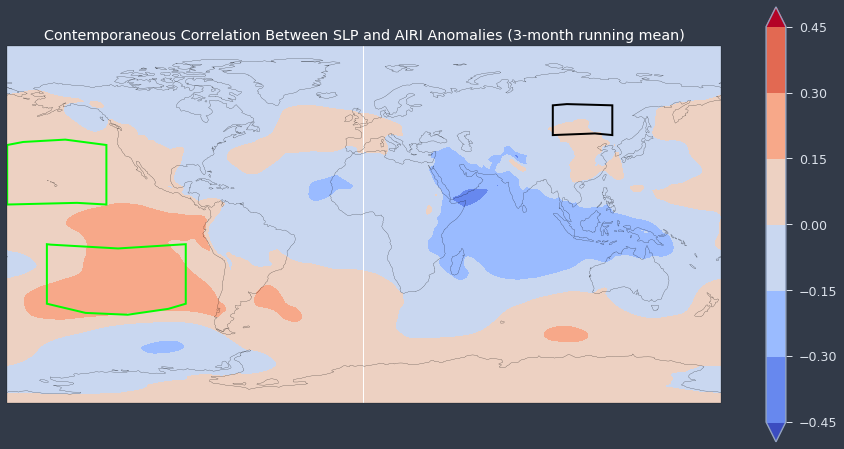

In [289]:
#Plot the result
ax = plt.axes(projection=ccrs.PlateCarree())
lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(slp_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
slp_r.plot.contourf(cmap='coolwarm',extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[-160,-40], width=70, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[-180,10], width=50, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=30, height=15, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#PSH: April–May mean SLP averaged over SP (40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)
#NAT: May minus March SLP averaged over(45°N–60°N, 95°E–125°E)
plt.title('Contemporaneous Correlation Between SLP and AIRI Anomalies (3-month running mean)', color = 'white')

In [334]:
#Try the same with only JJA:
julys=np.arange(6,1056,12)
slpa_jja = slpa_seasonal[julys,:,:]
precipa_jja = precipa_seasonal[julys]
slp_jja_r = correlation(slpa_jja,precipa_jja,dims='time')

Text(0.5, 1.0, 'Contemporaneous Correlation Between SLP and AIRI Anomalies (JJA Mean)')

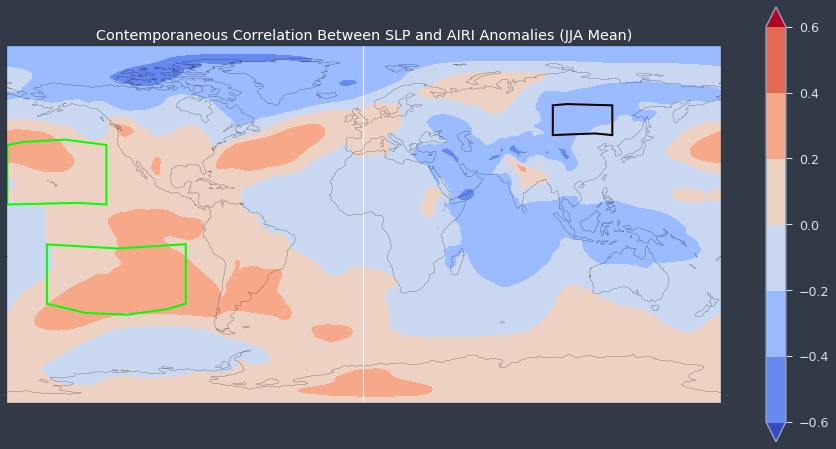

In [335]:
#Plot JJA correlation
ax = plt.axes(projection=ccrs.PlateCarree())
lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(slp_jja_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
slp_jja_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[-160,-40], width=70, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[-180,10], width=50, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=30, height=15, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#PSH: April–May mean SLP averaged over SP (40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)
#NAT: May minus March SLP averaged over(45°N–60°N, 95°E–125°E)
plt.title('Contemporaneous Correlation Between SLP and AIRI Anomalies (JJA Mean)', color = 'white')

In [336]:
#Try this with a lag of 3 months
slpa_seasonal_3shift = slpa_seasonal.shift(time=-3)
slpa_mam = slpa_seasonal_3shift[julys,:,:]

Text(0.5, 1.0, 'Green: Shifted SLPA (by 3 months)')

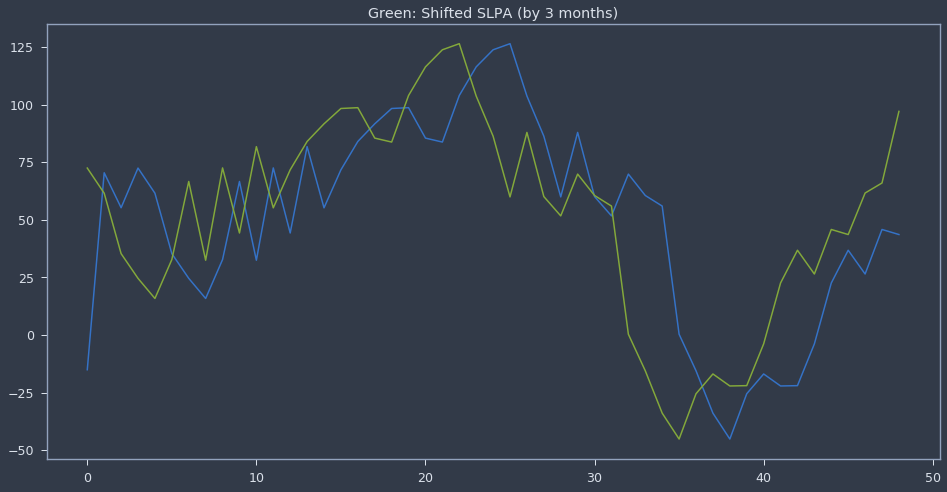

In [337]:
plt.plot(slpa_seasonal.sel(lon=270,lat=0,time=slice('1983-01-01','1988-01-01')))
plt.plot(slpa_seasonal_3shift.sel(lon=270,lat=0,time=slice('1983-01-01','1988-01-01')))
plt.title('Green: Shifted SLPA (by 3 months)')

In [338]:
#Run correlation
slp_mam_r = correlation(slpa_mam,precipa_jja,dims='time')
print(slp_mam_r)

<xarray.DataArray (lat: 181, lon: 360)>
array([[ 0.021932,  0.021932,  0.021932, ...,  0.021932,  0.021932,  0.021932],
       [ 0.030271,  0.030293,  0.030323, ...,  0.030179,  0.030207,  0.030246],
       [ 0.031877,  0.031919,  0.031952, ...,  0.031707,  0.031766,  0.031826],
       ...,
       [-0.320938, -0.321482, -0.322018, ..., -0.319308, -0.319859, -0.32041 ],
       [-0.315002, -0.315255, -0.315497, ..., -0.314232, -0.314492, -0.31475 ],
       [-0.30804 , -0.30804 , -0.30804 , ..., -0.30804 , -0.30804 , -0.30804 ]])
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0


Text(0.5, 1.0, 'Correlation Between MAM SLP and JJA AIRI Anomalies')

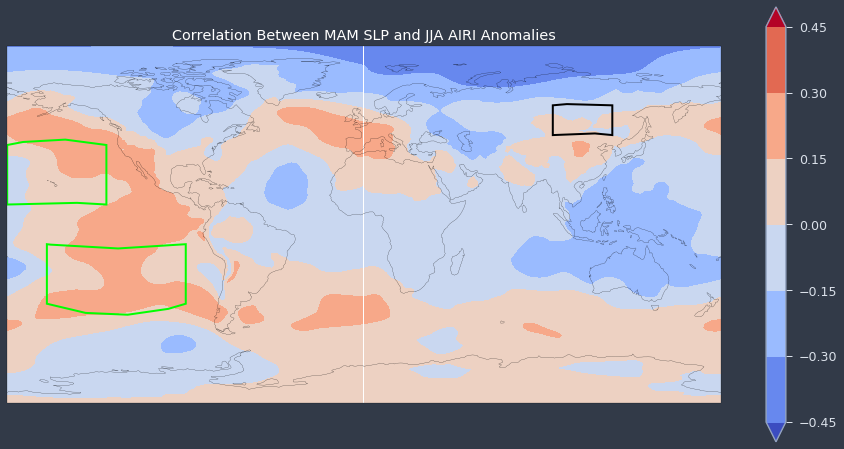

In [339]:
ax = plt.axes(projection=ccrs.PlateCarree())
#lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.colorbar()
slp_mam_r.plot.contourf(cmap='coolwarm',extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[-160,-40], width=70, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[-180,10], width=50, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=30, height=15, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#PSH: April–May mean SLP averaged over SP (40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)
#NAT: May minus March SLP averaged over(45°N–60°N, 95°E–125°E)
plt.title('Correlation Between MAM SLP and JJA AIRI Anomalies', color = 'white')

In [340]:
#Try May-March tendency and jjas AIRI to be more consistent with Wang paper
slpa_2shift_dt = slp_anom-slp_anom.shift(time=2) #This has the May minus March value at the May index
precipa_4seasonal = precip_anom.rolling(time=4).mean() #This has the JJAS mean at the Sep index
septembers = np.arange(8,1056,12)
precipa_jjas = precipa_4seasonal[septembers]
slpa_2shift_dt_sep = slpa_2shift_dt.shift(time=4)[septembers,:,:]

KeyError: 8

In [341]:
slp_may_mar_r = correlation(slpa_2shift_dt_sep,precipa_jjas,dims='time')

Text(0.5, 1.0, 'Correlation Between May-March SLPA and JJAS AIRI Anomalies')

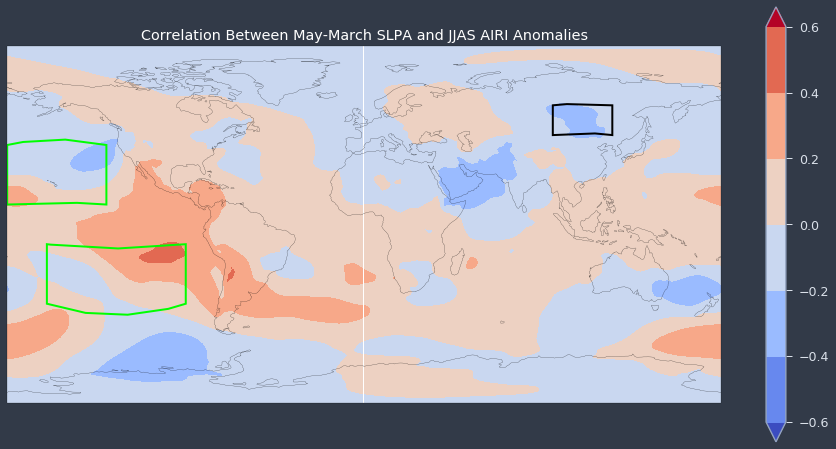

In [342]:
#Plot correlation
ax = plt.axes(projection=ccrs.PlateCarree())
lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(slp_may_mar_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
slp_may_mar_r.plot.contourf(cmap='coolwarm',extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[-160,-40], width=70, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[-180,10], width=50, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=30, height=15, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#PSH: April–May mean SLP averaged over SP (40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)
#NAT: May minus March SLP averaged over(45°N–60°N, 95°E–125°E)
plt.title('Correlation Between May-March SLPA and JJAS AIRI Anomalies', color = 'white')

In [299]:
# code editing
'''
slpa_seasonal = slp_anom.rolling(time=4,center=True).mean()
slpa_seasonal_3shift = slpa_seasonal.shift(time=-4)
slpa_mam_1 = slpa_seasonal_3shift[julys,:,:]
slp_mam_r = correlation(slpa_mam_1,precipa_jjas,dims='time')
#slp_mam_r.plot.contourf(cmap='coolwarm',extend='both')
'''

"\nslpa_seasonal = slp_anom.rolling(time=4,center=True).mean()\nslpa_seasonal_3shift = slpa_seasonal.shift(time=-4)\nslpa_mam_1 = slpa_seasonal_3shift[julys,:,:]\nslp_mam_r = correlation(slpa_mam_1,precipa_jjas,dims='time')\n#slp_mam_r.plot.contourf(cmap='coolwarm',extend='both')\n"

In [300]:
# Copyright (c) 2020 Medha Palavalli.